Import the package for the Clustering Task

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

from sklearn.metrics import (
    adjusted_rand_score,
    normalized_mutual_info_score,
    silhouette_score,
)

1. Load the MNIST dataset

In [18]:
# use fetch_openml, return as np.array 
mnist = fetch_openml("mnist_784", version=1, as_frame=False)
X = mnist.data.astype(np.float32)
y = mnist.target.astype(int)

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

X shape: (70000, 784)
y shape: (70000,)


2. Visualize sampled images and labels and show a grid plot with one row per class and five images per class.

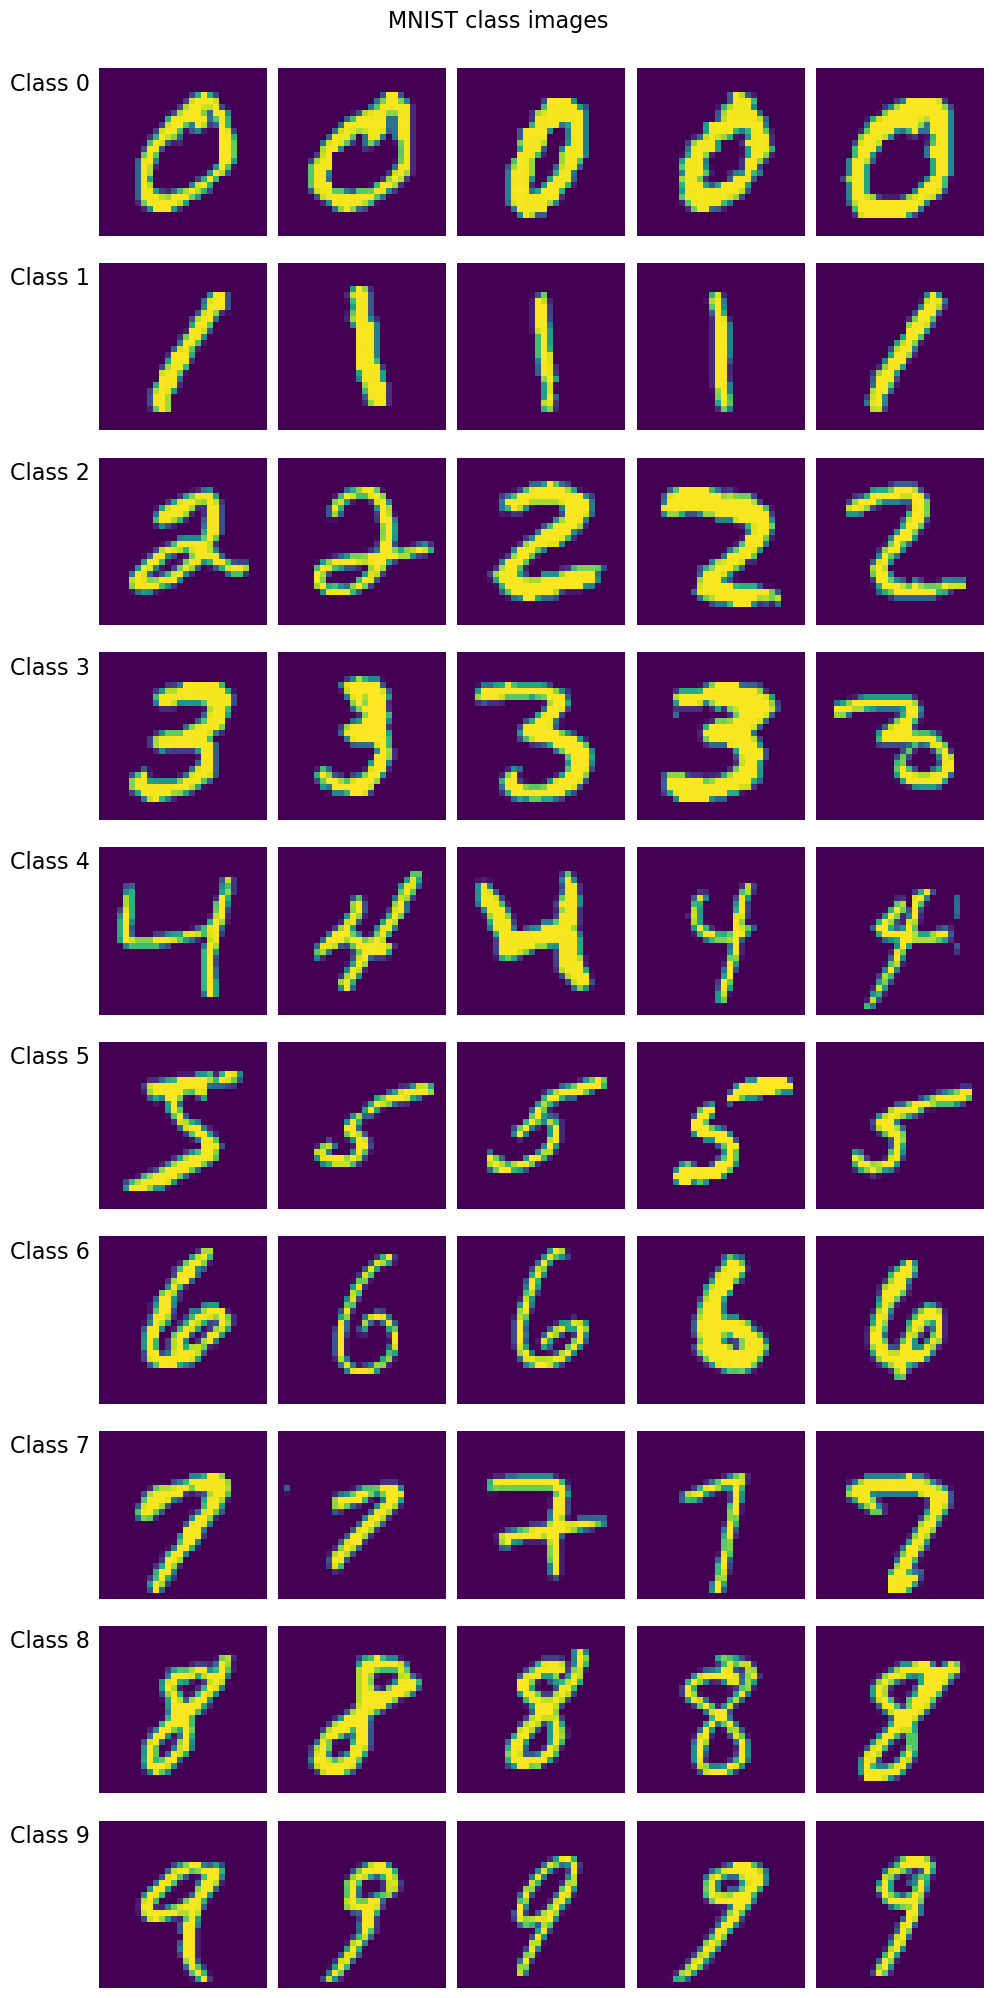

In [19]:
num_classes = 10 #0-9
images_per_class = 5 # each row contain 5 image

# create a grid plot with one row per class (0-9) 
# and each row contain 5 image in this class
fig, axes = plt.subplots(num_classes, images_per_class, figsize=(10, 20))

for num in range(num_classes):
    # find the first 5 indices that match the current number
    # np.where return a tuple so we need to extract the first element
    indices = np.where(y==num)[0][:images_per_class]

    for i, index in enumerate(indices):
        # need to reshape the image since original shape is 28*28
        img = X[index].reshape(28,28)
        ax = axes[num, i]
        ax.imshow(img)
        ax.axis("off")

        # label the row on the first image
        if i == 0:
            ax.text(
                -2, 2,           
                f"Class {num}",       
                fontsize=16,
                color="black",
                ha="right",
                va="center",
            )

plt.suptitle("MNIST class images", y=1.0, fontsize=16)
plt.tight_layout()
plt.savefig("clustering_images/true_grid_cluster.png")
plt.show()

3. Apply PCA to reduce 784 dimension to 50 to make training comoputationally feasible

In [20]:
pca = PCA(n_components=50)
pca.fit(X)
X_reduced = pca.transform(X)
print(f"X_reduced shape: {X_reduced.shape}")

X_reduced shape: (70000, 50)


4. Create a helper function for evaluating the model using the metrics of Adjusted Rand Index (ARI), Normalised Mutual Information (NMI) and Silhouette Score (SS)

In [21]:
# Return the score of Adjusted Rand Index, Normalised Mutual Information, Silhouette Score
def evaluate_score(X_reduced, y, y_pred):
    ari = adjusted_rand_score(y, y_pred)
    nmi = normalized_mutual_info_score(y, y_pred)
    ss = silhouette_score(X_reduced, y_pred)

    return ari, nmi, ss

5. Build a K-Mean Model with different hyperparameters

In [22]:
# Hyperparameter for K-Means: number of clusters and iterations for K-Means
n_clusters_params = [5, 8, 10, 12]
iterations = [10, 20, 30]

# use for generating the clustering results for K-Means
k_means_results = []
print("========== START K-MEANS HYPERPARAMETERS SELECTION ==========")
for K in n_clusters_params:
    for iteration in iterations:

        print(f"Running K-Means: number of clusters: {K}, number of iterations: {iteration}")
        # initialise KMeans with different hyperparameters
        k_means = KMeans(
            n_clusters=K,
            n_init=iteration,
            random_state=42,
        )
        k_means.fit(X_reduced)
        y_pred = k_means.predict(X_reduced)
        ari, nmi, ss = evaluate_score(X_reduced, y, y_pred)
        # store the model result
        k_means_results.append({
            "model": "K-Means",
            "n_clusters": K,
            "iteration": iteration,
            "ari": ari,
            "nmi": nmi,
            "ss": ss,
        })

print("========== FINISH K-MEANS HYPERPARAMETERS SELECTION ==========")

========== START K-MEANS HYPERPARAMETERS SELECTION ==========
Running K-Means: number of clusters: 5, number of iterations: 10
Running K-Means: number of clusters: 5, number of iterations: 20
Running K-Means: number of clusters: 5, number of iterations: 30
Running K-Means: number of clusters: 8, number of iterations: 10
Running K-Means: number of clusters: 8, number of iterations: 20
Running K-Means: number of clusters: 8, number of iterations: 30
Running K-Means: number of clusters: 10, number of iterations: 10
Running K-Means: number of clusters: 10, number of iterations: 20
Running K-Means: number of clusters: 10, number of iterations: 30
Running K-Means: number of clusters: 12, number of iterations: 10
Running K-Means: number of clusters: 12, number of iterations: 20
Running K-Means: number of clusters: 12, number of iterations: 30
========== FINISH K-MEANS HYPERPARAMETERS SELECTION ==========


6. Build a GMM with different hyperparameters

In [ ]:
# Hyperparameter for GMM: number of components and covariance matrix
n_components_params = [5, 8, 10, 12]
cov_types = ["full", "tied", "spherical", "diag"]
iterations = [100, 200]

# use for generating the clustering results for GMM
gmm_results = []
print("========== START GMM HYPERPARAMETERS SELECTION ==========")
for n_components in n_components_params:
    for cov_type in cov_types:
        for iteration in iterations:
            print(f"Running GMM: number of components={n_components}, covariance matrix type: {cov_type}")
            # initialise GMM with different hyperparameters
            gmm = GaussianMixture(
                n_components=n_components,
                covariance_type=cov_type,
                max_iter=iteration,
                random_state=42,
            )
    
            gmm.fit(X_reduced)
            y_pred = gmm.predict(X_reduced)
            # evaluate the model with the helper function
            ari, nmi, ss = evaluate_score(X_reduced, y, y_pred)
            # store the model result
            gmm_results.append({
                "model": "GMM",
                "n_components": n_components,
                "cov_type": cov_type,
                "ari": ari,
                "nmi": nmi,
                "ss": ss
            })

print("========== FINISH GMM HYPERPARAMETERS SELECTION ==========")

========== START GMM HYPERPARAMETERS SELECTION ==========
Running GMM: number of components=5, covariance matrix type: full
Running GMM: number of components=5, covariance matrix type: full
Running GMM: number of components=5, covariance matrix type: tied


7. Visualise clustering results, using the best-performing model and configuration.

In [ ]:
# Convert the K-Means and GMM results into panda data frame
k_means_df = pd.DataFrame(k_means_results)
gmm_df = pd.DataFrame(gmm_results)

# Concatenate two clustering results
results_df = pd.concat([k_means_df, gmm_df], ignore_index=True)
results_df = results_df.fillna("N/A")
# find the best-performing model for each metric
best_ari_row = results_df.sort_values("ari", ascending=False).iloc[0]
best_nmi_row = results_df.sort_values("nmi", ascending=False).iloc[0]
best_ss_row = results_df.sort_values("ss", ascending=False).iloc[0]

# Combine all 3 metrics with weighted scores
# I think ARI > NMI > SS

w_ari = 0.5
w_nmi = 0.3
w_ss = 1 - w_ari - w_nmi

results_df["combined_score"] = w_ari * results_df["ari"] + w_nmi * results_df["nmi"] + w_ss * results_df["ss"]
best_combined_row = results_df.sort_values("combined_score", ascending=False).iloc[0]

print("========== MODEL SELECTION SUMMARY ==========")

print("Best Adjusted Random Index (ARI) model:")
print(best_ari_row)
print("==================================================")
print("Best Normalised Mutual Information (NMI) model:")
print(best_nmi_row)
print("==================================================")
print("Best Silhouette Score (SS) model:")
print(best_ss_row)
print("==================================================")
print("Best Combined Score model:")
print(best_combined_row)
print("==================================================")

8. Show a grid plot with one row per cluster and five images per cluster with the best model

In [ ]:
# create a helper plot function for both K-Means and GMM clusters
def plot_clusters_grid(X, cluster_labels, title):
    # find the unique clusters (i.e. [0,...,9] if K = 10 or n_component = 10 depend on the model)
    unique_cluster = np.unique(cluster_labels)
    n_clusters = len(np.unique(cluster_labels))
    # Create a subplots for each label
    fig, axes = plt.subplots(n_clusters, 5, figsize=(10, n_clusters*2))

    for row, cluster_id in enumerate(unique_cluster):
        # indices of points in the current cluster i 
        indices = np.where(cluster_labels == cluster_id)[0][:5]

        for col, index in enumerate(indices):
            # reshape the image to 28*28
            img = X[index].reshape(28, 28)
            ax = axes[row, col]
            ax.imshow(img)
            ax.axis("off")

            # label the row on the first image
            if col == 0:
                ax.text(
                    -2, 2,           
                    f"Class {cluster_id}",       
                    fontsize=16,
                    color="black",
                    ha="right",
                    va="center",
                )

    plt.suptitle(title, y=1.02, fontsize=16)
    plt.tight_layout()
    plt.savefig("clustering_images/best_model_grid_cluster.png")
    plt.show()

# Return best model could be K-Means or GMM 
def refit_model(df_row, X_reduced):
    if df_row["model"] == "K-Means":
        model = KMeans(
            n_clusters=int(df_row["n_clusters"]),
            n_init=int(df_row["iteration"]),
            random_state=42,
        )    
        model.fit(X_reduced)
        labels = model.predict(X_reduced)
        return model, labels
    elif df_row["model"] == "GMM":
        model = GaussianMixture(
            n_components=int(df_row["n_components"]),
            covariance_type=df_row["cov_type"],
            random_state=42
        )
        model.fit(X_reduced)
        labels = model.predict(X_reduced)
        return model, labels
    
model, labels = refit_model(best_combined_row, X_reduced)
plot_clusters_grid(X, labels, title=f"Best model Clusters: ({best_combined_row['model']})")